# Clearing the dbfs environment & making it ready to accomodate new dataframes

In [0]:
# Clear the cache
spark.catalog.clearCache()

# Importing dependencies

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pyspark.sql.functions as func

# Importing the necessary classification algorithms
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier, NaiveBayes, GBTClassifier

# Importing MLflow and enabling autologging for PySpark ML
import mlflow
mlflow.pyspark.ml.autolog()
from pyspark.ml.feature import RFormula
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import TrainValidationSplit
from pyspark.ml.tuning import ParamGridBuilder

# Loading the data

In [0]:
# importing the data from the DBFS
FaultDataset = spark.read.csv("/FileStore/tables/FaultDataset.csv",
                             header = "true",
                             inferSchema = "true")
FaultDataset.show(10)

+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+--------------+
|        1|        2|        3|        4|        5|        6|        7|        8|        9|       10|       11|       12|       13|       14|       15|       16|       17|       18|       19|       20|fault_detected|
+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+--------------+
|0.3503125|0.3496875|     0.35|0.3459375|   0.3475|0.3459375| 0.341875|0.3434375|    0.355|0.3553125|0.3459375|   0.3525|   0.3575|0.3590625|  0.35875|0.3484375|0.3590625|     0.35|0.3559375|0.3490625|             0|
|0.5090625| 0.484375| 0.046875| 0.071875|     0.06|0.0634375|   0.0575|0.0546875|0.0559375| 0.058125|0.0628125| 0.065625|0.0640625|0

# Exploratory Data Analysis

#### Checking the data types

In [0]:
FaultDataset.printSchema()

root
 |-- 1: double (nullable = true)
 |-- 2: double (nullable = true)
 |-- 3: double (nullable = true)
 |-- 4: double (nullable = true)
 |-- 5: double (nullable = true)
 |-- 6: double (nullable = true)
 |-- 7: double (nullable = true)
 |-- 8: double (nullable = true)
 |-- 9: double (nullable = true)
 |-- 10: double (nullable = true)
 |-- 11: double (nullable = true)
 |-- 12: double (nullable = true)
 |-- 13: double (nullable = true)
 |-- 14: double (nullable = true)
 |-- 15: double (nullable = true)
 |-- 16: double (nullable = true)
 |-- 17: double (nullable = true)
 |-- 18: double (nullable = true)
 |-- 19: double (nullable = true)
 |-- 20: double (nullable = true)
 |-- fault_detected: integer (nullable = true)



### Checking the shape of the dataframe

In [0]:
# count the number of rows
num_rows = FaultDataset.count()

# get the number of columns
num_cols = len(FaultDataset.columns)

# print the shape of the DataFrame
print(f"FaultDataset shape: ({num_rows} rows , {num_cols} columns)")

FaultDataset shape: (9292 rows , 21 columns)


### Checking for missing values

In [0]:
# Checking for missing values
(
    FaultDataset
    .agg(*[
        func.sum(
            func.when(func.isnan(c) | func.col(c).isNull(), 1).otherwise(0)
        ).alias(c)
        for c in FaultDataset.columns
    ])
).show()

+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+--------------+
|  1|  2|  3|  4|  5|  6|  7|  8|  9| 10| 11| 12| 13| 14| 15| 16| 17| 18| 19| 20|fault_detected|
+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+--------------+
|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|             0|
+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+--------------+



### Changing the spark dataframe to a pandas dataframe for further exploration

In [0]:
fault_pd = FaultDataset.toPandas()
fault_pd

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,fault_detected
0,0.350313,0.349687,0.350000,0.345938,0.347500,0.345938,0.341875,0.343438,0.355000,0.355312,0.345938,0.352500,0.357500,0.359063,0.358750,0.348438,0.359063,0.350000,0.355938,0.349062,0
1,0.509062,0.484375,0.046875,0.071875,0.060000,0.063437,0.057500,0.054688,0.055938,0.058125,0.062812,0.065625,0.064062,0.063437,0.053437,0.084375,0.061562,0.053750,0.076875,0.056875,0
2,0.092813,0.097500,0.109687,0.102500,0.096250,0.105313,0.098750,0.098125,0.091875,0.090938,0.098750,0.103125,0.100000,0.103438,0.101562,0.097812,0.099062,0.103750,0.098125,0.104063,0
3,0.093750,0.089375,0.091875,0.099687,0.090938,0.096875,0.094062,0.096875,0.096875,0.099375,0.099375,0.095937,0.095937,0.094062,0.091250,0.099687,0.093750,0.093438,0.097187,0.094375,0
4,0.036875,0.044062,0.038125,0.042813,0.035312,0.034063,0.033125,0.040313,0.034688,0.036875,0.035625,0.036250,0.040938,0.039375,0.035000,0.040625,0.038437,0.036875,0.040000,0.037187,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9287,0.493125,0.493125,0.492812,0.490000,0.503437,0.483750,0.490312,0.495000,0.510312,0.495312,0.488750,0.496875,0.475313,0.490938,0.479687,0.494375,0.490000,0.492188,0.497188,0.496250,1
9288,0.516563,0.060000,0.060000,0.049063,0.059375,0.055000,0.471875,0.289062,0.071250,0.506875,0.053125,0.060312,0.295625,0.059062,0.053750,0.504375,0.053437,0.450937,0.051562,0.479375,1
9289,0.546562,0.055313,0.055313,0.620938,0.069687,0.595938,0.657188,0.678125,0.721250,0.706562,0.722500,0.723125,0.746250,0.731250,0.707187,0.596875,0.709375,0.723125,0.702500,0.707500,1
9290,0.505625,0.499063,0.490312,0.502812,0.497188,0.063437,0.481563,0.500313,0.051250,0.446875,0.054375,0.435312,0.463438,0.052500,0.068125,0.440312,0.048125,0.412500,0.066250,0.427812,1


### Summary Statistics

In [0]:
fault_pd.describe().T

,count,mean,std,min,25%,50%,75%,max
1,9292.0,0.341623,0.289195,0.024375,0.064062,0.342187,0.618437,1.080938
2,9292.0,0.342631,0.289088,0.024375,0.064609,0.343750,0.619062,1.213437
3,9292.0,0.342121,0.289164,0.024375,0.064375,0.342813,0.619062,1.080938
4,9292.0,0.342139,0.289164,0.024375,0.064375,0.342031,0.619062,1.080938
5,9292.0,0.342843,0.288965,0.024375,0.065000,0.343594,0.619062,1.080938
6,9292.0,0.342828,0.289089,0.024375,0.065000,0.343750,0.619062,1.080938
7,9292.0,0.342715,0.289195,0.024375,0.064687,0.342813,0.619141,1.080938
8,9292.0,0.343066,0.289192,0.024375,0.065312,0.343125,0.619687,1.080938
9,9292.0,0.343173,0.289340,0.024375,0.065000,0.342813,0.619766,1.080938
10,9292.0,0.343925,0.289012,0.024375,0.065937,0.345000,0.620000,1.080938


### Checking if the rows and columns are unique.

In [0]:
# check if the rows are unique
if fault_pd.index.is_unique:
    print("Rows are unique")
else:
    print("Rows are not unique")

# check if the columns are unique
if fault_pd.columns.is_unique:
    print("Columns are unique")
else:
    print("Columns are not unique")

Rows are unique
Columns are unique


### Checking for imbalance in the data

Out[14]: Text(0.5, 1.0, 'Distribution of Machines with and without faults')

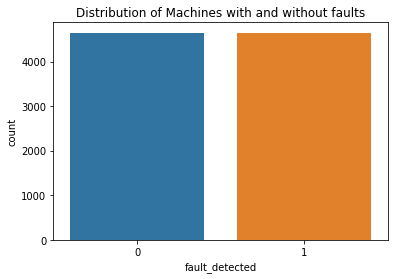

In [0]:
# create count plot
sns.countplot(x=fault_pd['fault_detected'])

# set plot title
plt.title('Distribution of Machines with and without faults')

# display the

In [0]:
(
    FaultDataset.groupBy("fault_detected")
    .count()
    .withColumn("percentage(%)", func.col("count")/FaultDataset.count()*100)
    .show()
)

+--------------+-----+-------------+
|fault_detected|count|percentage(%)|
+--------------+-----+-------------+
|             1| 4646|         50.0|
|             0| 4646|         50.0|
+--------------+-----+-------------+



### Outlier Detection

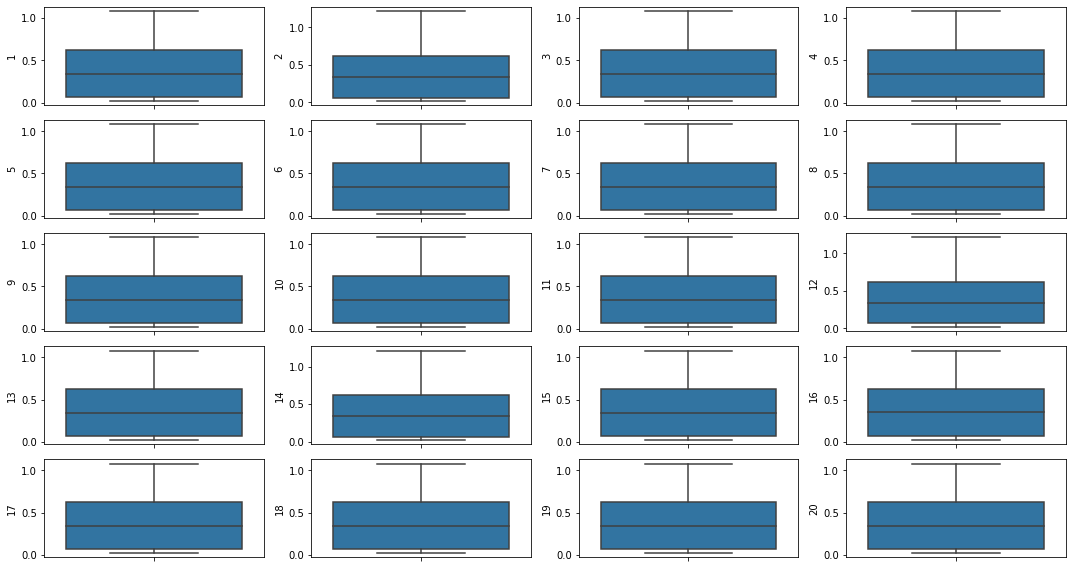

In [0]:
# Checking for outliers
plt.figure(figsize = (15,8))
for j in range(20):
    plt.subplot(5, 4, j+1)
    sns.boxplot(y = fault_pd.columns[j], data = fault_pd)
plt.tight_layout()
plt.show()

# Data Pre-processing

### Pre-processing the data to a MLib compliant format

In [0]:
preprocess = RFormula(formula = "fault_detected ~ .")
 
FaultDataset = preprocess.fit(FaultDataset).transform(FaultDataset)
 
FaultDataset.show(5)

2023/04/19 09:20:56 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '0f200a61f1db4ded8918a7a1ba0514a0', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow
+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+--------------+--------------------+-----+
|        1|        2|        3|        4|        5|        6|        7|        8|        9|       10|       11|       12|       13|       14|       15|       16|       17|       18|       19|       20|fault_detected|            features|label|
+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+--------------+--------------------+-----+
|0.3

### Splitting the data into training and test sets

In [0]:
(training_set, test_set) = FaultDataset.randomSplit([0.7, 0.3], seed = 100)

# Training the Models

# Decision Tree

In [0]:
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features")
 
# train the model
model_1 = dt.fit(training_set)

2023/04/19 09:21:22 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '93cc2940035641e18a9b4af32e5bf01a', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow
2023/04/19 09:21:30 WARNING mlflow.pyspark.ml: Model inputs contain unsupported Spark data types: [StructField('features', VectorUDT(), True)]. Model signature is not logged.
2023/04/19 09:22:29 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/databricks/python/lib/python3.9/site-packages/_distutils_hack/__init__.py:30: UserWarning: Setuptools is replacing distutils."


### Evaluating the Decision Tree Model

In [0]:
# making predictions based on the testset
predictions_1 = model_1.transform(test_set)

predictions_1.show(5)

+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+--------------+--------------------+-----+--------------+--------------------+----------+
|        1|        2|        3|        4|        5|        6|        7|        8|        9|       10|       11|       12|       13|       14|       15|       16|       17|       18|       19|       20|fault_detected|            features|label| rawPrediction|         probability|prediction|
+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+--------------+--------------------+-----+--------------+--------------------+----------+
|0.0253125| 0.039375|0.0528125| 0.056875|   0.0725| 0.041875|0.5109375|0.5628125|    0.605|   0.6025|0.6259375|      0.6|0.6090

### Checking the models accuracy

In [0]:
# using the accuracy metric as an evaluator to measure the accuracy of the model's predictions on the test data
evaluator_1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

accuracy_1 = evaluator_1.evaluate(predictions_1)

print(f"Decision Tree Model's Accuracy before hyperparameter tuning: {accuracy_1}")

Decision Tree Model's Accuracy before hyperparameter tuning: 0.9524324324324325


## Using MLflow & Viewing Run Details

### Using ParamGridBuilder & TrainValidationSplit for Grid Search

In [0]:
# creating a parameter grid
parameters_1 = ParamGridBuilder()\
.addGrid(dt.impurity,["gini", "entropy"])\
.addGrid(dt.maxDepth, [3, 5, 7])\
.addGrid(dt.maxBins, [16, 32, 64])\
.build()

In [0]:
#Defining the TrainValidationSplit
TVS_1 = TrainValidationSplit()\
.setSeed(50)\
.setTrainRatio(0.75)\
.setEstimatorParamMaps(parameters_1)\
.setEstimator(dt)\
.setEvaluator(evaluator_1)

### Perfroming Hyperparameter Tuning on the Decision Tree Model

In [0]:
gridsearch_Model_1 = TVS_1.fit(training_set)

2023/04/19 10:08:52 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'a6c3a0b7722846849c3e0bd9276307c6', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow


### The Paremeters of the Best Decision Tree Model

In [0]:
# Getting the parameters of the best performing model
bestModel_1 = gridsearch_Model_1.bestModel

print("Parameters for the best decision tree model:")
print(f"MaxDepth Parameter: {bestModel_1.getMaxDepth()}")
print(f"Impurity Parameter: {bestModel_1.getImpurity()}")
print(f"MaxBins Parameter: {bestModel_1.getMaxBins()}")

Parameters for the best decision tree model:
MaxDepth Parameter: 7
Impurity Parameter: entropy
MaxBins Parameter: 64


### Checking the accuracy of the best decison tree hyperparameter tuned model

In [0]:
# using the best performing model to make predictions on the test_set
hp_accuracy_1 = evaluator_1.evaluate(bestModel_1.transform(test_set))

print(f"Decision Tree Model's Accuracy after hyperparameter tuning: {hp_accuracy_1}")

Decision Tree Model's Accuracy after hyperparameter tuning: 0.961081081081081


### A code snippet to load and make predictions with the best decision tree hyperparameter tuned model

In [0]:
logged_model_1 = 'runs:/a6c3a0b7722846849c3e0bd9276307c6/best_model'

# Load model
loaded_model_1 = mlflow.spark.load_model(logged_model_1)

# Perform inference via model.transform()
loaded_predictions_1 = loaded_model_1.transform(test_set)

loaded_predictions_1.show()

2023/04/19 10:20:53 INFO mlflow.spark: 'runs:/a6c3a0b7722846849c3e0bd9276307c6/best_model' resolved as 'dbfs:/databricks/mlflow-tracking/2771711186885671/a6c3a0b7722846849c3e0bd9276307c6/artifacts/best_model'
2023/04/19 10:20:57 INFO mlflow.spark: File 'dbfs:/databricks/mlflow-tracking/2771711186885671/a6c3a0b7722846849c3e0bd9276307c6/artifacts/best_model/sparkml' not found on DFS. Will attempt to upload the file.
2023/04/19 10:20:58 INFO mlflow.spark: Copied SparkML model to /tmp/mlflow/07433c5b-3b4b-46ab-864d-0ead7f5c4da5
+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+--------------+--------------------+-----+-------------+--------------------+----------+
|        1|        2|        3|        4|        5|        6|        7|        8|        9|       10|       11|       12|       13|       14|       15|       16|       17|       18

# Random Forest

In [0]:
rf = RandomForestClassifier(labelCol="label", featuresCol="features")
 
# train the model
model_2 = rf.fit(training_set)

2023/04/19 10:21:55 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'b3e728fe139a4049aac70151fc684eb7', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow


### Evaluating the Random Forest Model

In [0]:
# making predictions based on the testset
predictions_2 = model_2.transform(test_set)

predictions_2.show()

+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+--------------+--------------------+-----+--------------------+--------------------+----------+
|        1|        2|        3|        4|        5|        6|        7|        8|        9|       10|       11|       12|       13|       14|       15|       16|       17|       18|       19|       20|fault_detected|            features|label|       rawPrediction|         probability|prediction|
+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+--------------+--------------------+-----+--------------------+--------------------+----------+
|0.0253125| 0.039375|0.0528125| 0.056875|   0.0725| 0.041875|0.5109375|0.5628125|    0.605|   0.6025|0.625937

### Checking the models accuracy

In [0]:
# using the accuracy metric as an evaluator to measure the accuracy of the model's predictions on the test data
evaluator_2 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

accuracy_2 = evaluator_2.evaluate(predictions_2)

print(f"The Random Forest Model's Accuracy before hyperparameter tuning: {accuracy_2}")

The Random Forest Model's Accuracy before hyperparameter tuning: 0.9679279279279279


## Using MLflow & Viewing Run Details

### Using ParamGridBuilder & TrainValidationSplit for Grid Search

In [0]:
# creating a parameter grid
parameters_2 = ParamGridBuilder()\
.addGrid(rf.featureSubsetStrategy, ["auto", "sqrt", "log2"])\
.addGrid(rf.subsamplingRate,[0.1, 0.5, 1.0])\
.addGrid(rf.minInfoGain, [0.0, 0.3, 0.5])\
.addGrid(rf.numTrees, [10, 100, 1000])\
.build()

In [0]:
#Defining the TrainValidationSplit
TVS_2 = TrainValidationSplit()\
.setSeed(50)\
.setTrainRatio(0.75)\
.setEstimatorParamMaps(parameters_2)\
.setEstimator(rf)\
.setEvaluator(evaluator_2)

### Perfroming Hyperparameter Tuning on the Random Forest Model

In [0]:
gridsearch_Model_2 = TVS_2.fit(training_set)

2023/04/19 10:26:11 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'fbabadb3aba94a9680545ec15456f35e', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow


### The Paremeters of the Best Random Forest Model

In [0]:
# Getting the parameters of the best performing model
bestModel_2 = gridsearch_Model_2.bestModel

print("Parameters for the best random forest model:")
print(f"Best numTrees: {bestModel_2.getOrDefault('numTrees')}")
print(f"Best minInfoGain: {bestModel_2.getOrDefault('minInfoGain')}")
print(f"Best subsamplingRate: {bestModel_2.getOrDefault('subsamplingRate')}")
print(f"Best featureSubsetStrategy: {bestModel_2.getOrDefault('featureSubsetStrategy')}")

Parameters for the best random forest model:
Best numTrees: 10
Best minInfoGain: 0.0
Best subsamplingRate: 1.0
Best featureSubsetStrategy: auto


### Checking the accuracy of the best random forest hyperparameter tuned model

In [0]:
# using the best performing model to make predictions on the test_set
hp_accuracy_2 = evaluator_2.evaluate(bestModel_2.transform(test_set))

print(f"Random Forest Model's Accuracy after hyperparameter tuning: {hp_accuracy_2}")

Random Forest Model's Accuracy after hyperparameter tuning: 0.9650450450450451


### Code snippet to load and make predictions with the best random forest hyperparameter tuned model

In [0]:
logged_model_2 = 'runs:/fbabadb3aba94a9680545ec15456f35e/best_model'

# Load model
loaded_model_2 = mlflow.spark.load_model(logged_model_2)

# Perform inference via model.transform()
loaded_predictions_2 = loaded_model_2.transform(test_set)

loaded_predictions_2.show()

2023/04/19 10:49:11 INFO mlflow.spark: 'runs:/fbabadb3aba94a9680545ec15456f35e/best_model' resolved as 'dbfs:/databricks/mlflow-tracking/2771711186885671/fbabadb3aba94a9680545ec15456f35e/artifacts/best_model'
2023/04/19 10:49:15 INFO mlflow.spark: File 'dbfs:/databricks/mlflow-tracking/2771711186885671/fbabadb3aba94a9680545ec15456f35e/artifacts/best_model/sparkml' not found on DFS. Will attempt to upload the file.
2023/04/19 10:49:17 INFO mlflow.spark: Copied SparkML model to /tmp/mlflow/43e8f8f4-a39a-41ae-90a5-b8f6fe5514f3
+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+--------------+--------------------+-----+--------------------+--------------------+----------+
|        1|        2|        3|        4|        5|        6|        7|        8|        9|       10|       11|       12|       13|       14|       15|       16|       17|  

# GBTClassifier

In [0]:
gbt = GBTClassifier(labelCol="label", featuresCol="features")

# train the model
model_3 = gbt.fit(training_set)

2023/04/19 10:49:31 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '7201e6ab315f444f8c2e03d39fb2eae1', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow


### Evaluating the GBTClassifier Model

In [0]:
# making predictions based on the testset
predictions_3 = model_3.transform(test_set)

predictions_3.show()

+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+--------------+--------------------+-----+--------------------+--------------------+----------+
|        1|        2|        3|        4|        5|        6|        7|        8|        9|       10|       11|       12|       13|       14|       15|       16|       17|       18|       19|       20|fault_detected|            features|label|       rawPrediction|         probability|prediction|
+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+--------------+--------------------+-----+--------------------+--------------------+----------+
|0.0253125| 0.039375|0.0528125| 0.056875|   0.0725| 0.041875|0.5109375|0.5628125|    0.605|   0.6025|0.625937

### Checking the models accuracy

In [0]:
# using the accuracy metric as an evaluator to measure the accuracy of the model's predictions on the test data
evaluator_3 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

accuracy_3 = evaluator_3.evaluate(predictions_3)

print(f"The GBTClassifier Model's Accuracy before hyperparameter tuning: {accuracy_3}")

The GBTClassifier Model's Accuracy before hyperparameter tuning: 0.9614414414414414


## Using MLflow & Viewing Run Details

### Using ParamGridBuilder & TrainValidationSplit for Grid Search

In [0]:
# creating a parameter grid
parameters_3 = ParamGridBuilder()\
.addGrid(gbt.lossType, ["logistic"])\
.addGrid(gbt.maxIter,[10, 20, 50])\
.addGrid(gbt.minInstancesPerNode, [1, 5, 10])\
.addGrid(gbt.stepSize, [0.05, 0.1, 0.2])\
.build()

In [0]:
#Defining the TrainValidationSplit
TVS_3 = TrainValidationSplit()\
.setSeed(50)\
.setTrainRatio(0.75)\
.setEstimatorParamMaps(parameters_3)\
.setEstimator(gbt)\
.setEvaluator(evaluator_3)

### Perfroming Hyperparameter Tuning on the GBTClassifier Model

In [0]:
gridsearch_Model_3 = TVS_3.fit(training_set)

2023/04/19 10:51:16 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'ccfcab292906477091b47aafdd97b4d0', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow


### The Paremeters of the Best GBTClassifier Model

In [0]:
# Getting the parameters of the best performing model
bestModel_3 = gridsearch_Model_3.bestModel

print("Parameters for the best GBTClassifier model:")
print(f"Best lossType: {bestModel_3.getOrDefault('lossType')}")
print(f"Best maxIter: {bestModel_3.getOrDefault('maxIter')}")
print(f"Best minInstancesPerNode: {bestModel_3.getOrDefault('minInstancesPerNode')}")
print(f"Best stepSizey: {bestModel_3.getOrDefault('stepSize')}")

Parameters for the best GBTClassifier model:
Best lossType: logistic
Best maxIter: 50
Best minInstancesPerNode: 10
Best stepSizey: 0.1


### Checking the accuracy of the best GBTClassifier hyperparameter tuned model

In [0]:
# using the best performing model to make predictions on the test_set
hp_accuracy_3 = evaluator_3.evaluate(bestModel_3.transform(test_set))

print(f"GBTClassifier Model's Accuracy after hyperparameter tuning: {hp_accuracy_3}")

GBTClassifier Model's Accuracy after hyperparameter tuning: 0.9657657657657658


### Code snippet to load and make predictions with the best gbtclassifier hyperparameter tuned model

In [0]:
logged_model_3 = 'runs:/ccfcab292906477091b47aafdd97b4d0/best_model'

# Load model
loaded_model_3 = mlflow.spark.load_model(logged_model_3)

# Perform inference via model.transform()
loaded_predictions_3 = loaded_model_3.transform(test_set)

loaded_predictions_3.show()

2023/04/19 12:06:05 INFO mlflow.spark: 'runs:/ccfcab292906477091b47aafdd97b4d0/best_model' resolved as 'dbfs:/databricks/mlflow-tracking/2771711186885671/ccfcab292906477091b47aafdd97b4d0/artifacts/best_model'
2023/04/19 12:06:09 INFO mlflow.spark: File 'dbfs:/databricks/mlflow-tracking/2771711186885671/ccfcab292906477091b47aafdd97b4d0/artifacts/best_model/sparkml' not found on DFS. Will attempt to upload the file.
2023/04/19 12:06:11 INFO mlflow.spark: Copied SparkML model to /tmp/mlflow/d29520cf-be74-42ac-81b2-777640f07a37
+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+--------------+--------------------+-----+--------------------+--------------------+----------+
|        1|        2|        3|        4|        5|        6|        7|        8|        9|       10|       11|       12|       13|       14|       15|       16|       17|  

# Naive Bayes

In [0]:
nb = NaiveBayes(labelCol="label", featuresCol="features")
 
# train the model
model_4 = nb.fit(training_set)

2023/04/19 12:59:20 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '1391439f01fa4019ad05c3f35b002595', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow


### Evaluating the Linear Support Vector Machine Model

In [0]:
# making predictions based on the testset
predictions_4= model_4.transform(test_set)

predictions_4.show()

+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+--------------+--------------------+-----+--------------------+--------------------+----------+
|        1|        2|        3|        4|        5|        6|        7|        8|        9|       10|       11|       12|       13|       14|       15|       16|       17|       18|       19|       20|fault_detected|            features|label|       rawPrediction|         probability|prediction|
+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+--------------+--------------------+-----+--------------------+--------------------+----------+
|0.0253125| 0.039375|0.0528125| 0.056875|   0.0725| 0.041875|0.5109375|0.5628125|    0.605|   0.6025|0.625937

### Checking the models accuracy

In [0]:
#usinng the accuracy metric as an evaluator to measure the accuracy of the model's predictions on the test data
evaluator_4 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

accuracy_4 = evaluator_4.evaluate(predictions_4)

print(f"The Naive Bayes Model's Accuracy before hyperparameter tuning: {accuracy_4}")

The Naive Bayes Model's Accuracy before hyperparameter tuning: 0.5596396396396396


## Using MLflow & Viewing Run Details

### Using ParamGridBuilder & TrainValidationSplit for Grid Search

In [0]:
# creating a parameter grid
parameters_4 = ParamGridBuilder()\
.addGrid(nb.modelType, ["multinomial", "gaussian"])\
.addGrid(nb.smoothing, [0.5, 1.0, 1.5])\
.build()

In [0]:
#defining the TrainValidationSplit
TVS_4 = TrainValidationSplit()\
.setSeed(50)\
.setTrainRatio(0.75)\
.setEstimatorParamMaps(parameters_4)\
.setEstimator(nb)\
.setEvaluator(evaluator_4)

### Perfroming Hyperparameter Tuning on the Naive Bayes Model

In [0]:
gridsearch_Model_4 = TVS_4.fit(training_set)

2023/04/19 13:27:49 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'eaa2033ec7574d18ba1888d12efaebaf', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow


### The Paremeters of the Best Naive Bayes Model

In [0]:
# Getting the parameters of the best performing model
bestModel_4 = gridsearch_Model_4.bestModel

print("Parameters for the best GBTClassifier model:")
print(f"Best lossType: {bestModel_4.getOrDefault('modelType')}")
print(f"Best lossType: {bestModel_4.getOrDefault('smoothing')}")

Parameters for the best GBTClassifier model:
Best lossType: gaussian
Best lossType: 0.5


### Checking the accuracy of the best Naive Bayes hyperparameter tuned model

In [0]:
# using the best performing model to make predictions on the test_set
hp_accuracy_4 = evaluator_4.evaluate(bestModel_4.transform(test_set))

print(f"Random Forest Model's Accuracy after hyperparameter tuning = {hp_accuracy_4}")

Random Forest Model's Accuracy after hyperparameter tuning = 0.8590990990990991


### Code snippet to load and make predictions with the best naive bayes hyperparameter tuned model

In [0]:
logged_model_4 = 'runs:/eaa2033ec7574d18ba1888d12efaebaf/best_model'

# Load model
loaded_model_4 = mlflow.spark.load_model(logged_model_4)

# Perform inference via model.transform()
loaded_predictions_4 = loaded_model_4.transform(test_set)

loaded_predictions_4.show()

2023/04/19 13:35:23 INFO mlflow.spark: 'runs:/eaa2033ec7574d18ba1888d12efaebaf/best_model' resolved as 'dbfs:/databricks/mlflow-tracking/2771711186885671/eaa2033ec7574d18ba1888d12efaebaf/artifacts/best_model'
2023/04/19 13:35:26 INFO mlflow.spark: File 'dbfs:/databricks/mlflow-tracking/2771711186885671/eaa2033ec7574d18ba1888d12efaebaf/artifacts/best_model/sparkml' not found on DFS. Will attempt to upload the file.
2023/04/19 13:35:28 INFO mlflow.spark: Copied SparkML model to /tmp/mlflow/b3833d1a-c033-40cd-9852-9151aad918e6
+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+--------------+--------------------+-----+--------------------+--------------------+----------+
|        1|        2|        3|        4|        5|        6|        7|        8|        9|       10|       11|       12|       13|       14|       15|       16|       17|  